#Imports and Downloads

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!pip install wandb -q
!pip install foolbox==3.3.1
!cd '/content/drive/MyDrive/ESE546_Final_Project/'

In [ ]:
from __future__ import print_function
import argparse
import os
from copy import deepcopy
import random
import matplotlib.pyplot as plt
import PIL
import numpy as np
from scipy import ndimage
import cv2
from cv2 import fastNlMeansDenoisingColored, cvtColor 
from skimage.restoration import denoise_nl_means, estimate_sigma
import math

# torch and torchvision imports
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data import TensorDataset

# WandB – Import the wandb library
import wandb
# FoolBox - import the foolbox library
import eagerpy as ep
import foolbox as fb
from foolbox import PyTorchModel, accuracy, samples
from foolbox.attacks import *

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')     
wandb.login() # login to wandb to remotely track performance
root_dir = '/content/drive/MyDrive/ESE546_Final_Project/'

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


#Model Architectures

In [ ]:
# Defining the model (All-CNN Architecture is the same as used in previous homeworks)

class View(nn.Module):
    def __init__(self,o):
        super().__init__()
        self.o = o

    def forward(self,x):
        return x.view(-1, self.o)
    
class allcnn_t(nn.Module):
    def __init__(self, c1=96, c2= 192):
        super().__init__()
        d = 0.5

        def convbn(ci,co,ksz,s=1,pz=0):
            return nn.Sequential(
                nn.Conv2d(ci,co,ksz,stride=s,padding=pz),
                nn.ReLU(True),
                nn.BatchNorm2d(co))

        self.m = nn.Sequential(
            nn.Dropout(0.2),
            convbn(3,c1,3,1,1),
            convbn(c1,c1,3,1,1),
            convbn(c1,c1,3,2,1),
            nn.Dropout(d),
            convbn(c1,c2,3,1,1),
            convbn(c2,c2,3,1,1),
            convbn(c2,c2,3,2,1),
            nn.Dropout(d),
            convbn(c2,c2,3,1,1),
            convbn(c2,c2,3,1,1),
            convbn(c2,10,1,1),
            nn.AvgPool2d(8),
            View(10))

        print('Num parameters: ', sum([p.numel() for p in self.m.parameters()]))

    def forward(self, x):
        return self.m(x)


In [ ]:
def createMobileNetModel(pretrained=True, num_classes=10, feature_extracting=True):
    # Create a model instance of the MobileNet V2 Architecture, pretrained on ImageNet
    model = torchvision.models.mobilenet_v2(pretrained=pretrained)
    # If specified, freeze the feature extractor
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False
    # Replace the classifier (which outputs 1000 classes for ImageNet) with a classifier which outputs 10 classes for CIFAR-10
    model.classifier[1] = nn.Linear(in_features=model.last_channel, out_features=num_classes)
    return model

#Training and Validation Functions

In [ ]:
# validation inner loop
def validate(model, test_loader):
    val_correct = 0
    epoch_val_loss = 0
    val_total = 0
    for i, (images, labels) in enumerate(test_loader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        _, predicted = torch.max(outputs.data, 1)
        val_correct += (predicted == labels).sum().item()
        epoch_val_loss += loss.item()
        val_total += labels.size(0)

    epoch_val_error = 1.0 - (val_correct / val_total)
    epoch_val_loss = epoch_val_loss / val_total
    return epoch_val_error, epoch_val_loss

# The training loop
def train(net, optimizer, scheduler, criterion, train_loader, test_loader, epochs, model_name):
    model = net.to(device)
    total_step = len(train_loader)
    overall_step = 0
    for epoch in range(epochs):
        correct = 0
        epoch_loss = 0
        total = 0
        model.train()
        for i, (images, labels) in enumerate(train_loader):
            if scheduler is None:
                # Update LR according to Cosine Annealing Warmup (discussed further down)
                next_lr = lr_scheduler_impl(total_step, epoch, i)
                for g in optimizer.param_groups:
                    g['lr'] = next_lr
            else:
                next_lr = scheduler.get_last_lr()[0]
            # Move tensors to configured device
            images = images.to(device)
            labels = labels.to(device)
            # Forward Pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            # Compute loss and error
            _, predicted = torch.max(outputs.data, 1)
            iter_correct = (predicted == labels).sum().item()
            correct += iter_correct
            epoch_loss += loss.item()
            total += labels.size(0)
            # Log per weight Update
            wandb.log({"Iteration Training Loss": loss.item(),
                       "Iteration Training Error": 1.0 - (iter_correct / labels.size(0)),
                       "Iteration LR": next_lr,
                       "Iteration": epoch*total_step + i})
            # Backpropogation and SGD
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (i+1) % config.batch_size == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, epochs, i+1, total_step, loss.item()))
        # log training metrics
        epoch_error = 1.0 - (correct / total)
        epoch_loss = epoch_loss / total
        wandb.log({"Epoch Training Loss": epoch_loss,
                   "Epoch Training Error": epoch_error,
                   "Epoch LR": next_lr,
                   "Epoch": epoch,
                   "Iteration": (epoch + 1)*total_step})

        ################ Validation ################
        model.eval()
        with torch.no_grad():
            epoch_val_error, epoch_val_loss = validate(model, test_loader)
        if scheduler is not None:
            scheduler.step()
        # log validation metrics
        wandb.log({"Validation Loss": epoch_val_loss,
                   "Validation Error": epoch_val_error,
                   "Epoch": epoch,
                   "Iteration": (epoch + 1)*total_step})
        print('Error of the network on the test images: {} %'.format(100 * epoch_val_error))

        if (epoch+1) % 3 == 0 and epoch+1 != epochs:
            if epoch+1 < 10:
                checkpoint = "epoch0" + str(epoch+1) + ".h5"
            else:
                checkpoint = "epoch" + str(epoch+1) + ".h5"
            save_name = root_dir + "models/" + model_name + "/" + checkpoint
            torch.save(model.state_dict(), save_name)

#Base Model Training

Train the ALL-CNN Architecture using the same final hyperparameters from Homework 4

In [ ]:
# WandB – Initialize a new run
wandb.init(project="ese546-finalproj",
           group="Baseline Training",
           name="benchmark")
wandb.watch_called = False # Re-run the model without restarting the runtime, unnecessary after our next release

# WandB – Config is a variable that holds and saves hyperparameters and inputs
config = wandb.config                              # Initialize config
config.batch_size = 128                            # input batch size for training
config.test_batch_size = int(256 / 2.5)            # input batch size for testing
config.epochs = 35                                 # number of epochs to train
config.lr = 0.1                                    # learning rate
config.momentum = 0.9                              # SGD momentum
config.weight_decay = 1e-3                         # Weight decay
config.nesterov = True                             # Nesterov momentum
config.seed = 42                                   # random seed (default: 42)
config.model_name = "BASELINE"                     # Save folder for model checkpoints
config.lr_steps = [int(0.4*config.epochs), int(0.8*config.epochs)]

In [ ]:
# Set random seeds for reproducability
torch.manual_seed(config.seed)
random.seed(config.seed)
np.random.seed(config.seed)

In [ ]:
#  Define classes in the CIFAR dataset
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Define transforms
transform_train = transforms.Compose([transforms.AutoAugment(policy=transforms.autoaugment.AutoAugmentPolicy.CIFAR10, 
                                                             interpolation=transforms.functional.InterpolationMode.BILINEAR),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

transform_test = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Read the datasets for training and testing, and create the corresponding dataloaders
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=config.batch_size,
                                          shuffle=True, pin_memory=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=config.test_batch_size,
                                         shuffle=False, pin_memory=True)

# Initialize a new model
model = allcnn_t().to(device)
# Define the loss function as asked in the question
criterion = nn.CrossEntropyLoss()
# Set optimizer and scheduler
optimizer = optim.SGD(model.parameters(), lr=config.lr, momentum=config.momentum, weight_decay=config.weight_decay, nesterov=config.nesterov)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer=optimizer, milestones=config.lr_steps)
# Training loop called here
train(model, optimizer, scheduler, criterion, trainloader, testloader, config.epochs, config.model_name)
# Save the model
final_model_name = root_dir + 'models/' + config.model_name + '/final.h5'
torch.save(model.state_dict(), final_model_name)

# Finding the Optimal Learning Rate

In [ ]:
# WandB – Initialize a new run
wandb.init(project="ese546-finalproj", 
           group="learning_rate_finding", 
           name="mobilenetv2 experiment 1")
wandb.watch_called = False # Re-run the model without restarting the runtime, unnecessary after our next release

# WandB – Config is a variable that holds and saves hyperparameters and inputs
config = wandb.config                              # Initialize config
config.batch_size = 128                            # input batch size for training
config.test_batch_size = int(256 / 2.5)            # input batch size for testing
config.epochs = 150                                # number of epochs to train
config.lr = 1e-5                                   # learning rate
config.momentum = 0.9                              # SGD momentum
config.weight_decay = 1e-3                         # Weight decay
config.nesterov = True                             # Nesterov momentum
config.seed = 42                                   # random seed (default: 42)

Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
LR,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▃▃▄▆█
Training Loss (LR Finder),▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▃▅▄▅█
Epoch,149
LR,14.70653
Training Loss (LR Finder),1809.94092


In [ ]:
# Set random seeds for reproducability
torch.manual_seed(config.seed)
random.seed(config.seed)
np.random.seed(config.seed)

In [ ]:
def lr_finder_algo(net, optimizer, scheduler, criterion, train_loader, epochs):
    model = net.to(device)
    losses = []
    for epoch, (images, labels) in enumerate(train_loader):
        if epoch == epochs:
            break;
        # Move tensors to configured device
        images = images.to(device)
        labels = labels.to(device)
        # Forward Pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        # Backpropogation and SGD
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        curr_lr = optimizer.param_groups[0]['lr']
        wandb.log({"Training Loss (LR Finder)": loss.item(),
                   "LR": curr_lr,
                   "Epoch": epoch})
        losses.append(loss.item())
        scheduler.step()
    return losses

In [ ]:
#  Define classes in the CIFAR dataset
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Define transforms
transform_train = transforms.Compose([transforms.AutoAugment(policy=transforms.autoaugment.AutoAugmentPolicy.CIFAR10, 
                                                             interpolation=transforms.functional.InterpolationMode.BILINEAR),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

transform_test = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Read the datasets for training and testing, and create the corresponding dataloaders
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=config.batch_size,
                                          shuffle=True, pin_memory=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=config.test_batch_size,
                                         shuffle=False, pin_memory=True)

Files already downloaded and verified
Files already downloaded and verified


###All CNN Tuning

In [ ]:
# Initialize a new model
model = allcnn_t().to(device)
# Define the loss function as asked in the question
criterion = nn.CrossEntropyLoss()
# Set optimizer and scheduler
optimizer = optim.SGD(model.parameters(), lr=config.lr, momentum=config.momentum, weight_decay=config.weight_decay, nesterov=config.nesterov)
# Define Scheduler for Learning Rate Finding Algorithm
lr_fcn = lambda epoch: 1.1
scheduler = optim.lr_scheduler.MultiplicativeLR(optimizer, lr_fcn, last_epoch=-1, verbose=True)
# Call Learning Rate Algorithm
lr_losses = lr_finder_algo(model, optimizer, scheduler, criterion, trainloader, config.epochs)

###MobileNetV2 Tuning

In [ ]:
# Initialize a new model
model = createMobileNetModel(pretrained=True, num_classes=10, feature_extracting=False).to(device)
# Define the loss function as asked in the question
criterion = nn.CrossEntropyLoss()
# Set optimizer and scheduler
optimizer = optim.SGD(model.parameters(), lr=config.lr, momentum=config.momentum, weight_decay=config.weight_decay, nesterov=config.nesterov)
# Define Scheduler for Learning Rate Finding Algorithm
lr_fcn = lambda epoch: 1.1
scheduler = optim.lr_scheduler.MultiplicativeLR(optimizer, lr_fcn, last_epoch=-1, verbose=True)
# Call Learning Rate Algorithm
lr_losses = lr_finder_algo(model, optimizer, scheduler, criterion, trainloader, config.epochs)

Adjusting learning rate of group 0 to 1.0000e-05.
Adjusting learning rate of group 0 to 1.1000e-05.
Adjusting learning rate of group 0 to 1.2100e-05.
Adjusting learning rate of group 0 to 1.3310e-05.
Adjusting learning rate of group 0 to 1.4641e-05.
Adjusting learning rate of group 0 to 1.6105e-05.
Adjusting learning rate of group 0 to 1.7716e-05.
Adjusting learning rate of group 0 to 1.9487e-05.
Adjusting learning rate of group 0 to 2.1436e-05.
Adjusting learning rate of group 0 to 2.3579e-05.
Adjusting learning rate of group 0 to 2.5937e-05.
Adjusting learning rate of group 0 to 2.8531e-05.
Adjusting learning rate of group 0 to 3.1384e-05.
Adjusting learning rate of group 0 to 3.4523e-05.
Adjusting learning rate of group 0 to 3.7975e-05.
Adjusting learning rate of group 0 to 4.1772e-05.
Adjusting learning rate of group 0 to 4.5950e-05.
Adjusting learning rate of group 0 to 5.0545e-05.
Adjusting learning rate of group 0 to 5.5599e-05.
Adjusting learning rate of group 0 to 6.1159e-05.


#Cosine Annealing with Warmup Learning Rate Schedule

In [ ]:
# WandB – Initialize a new run
wandb.init(project="ese546-finalproj", 
           group="Cosine Annealing", 
           name="CAW LR Experiment 3")
wandb.watch_called = False # Re-run the model without restarting the runtime, unnecessary after our next release

# WandB – Config is a variable that holds and saves hyperparameters and inputs
config = wandb.config                              # Initialize config
config.batch_size = 128                            # input batch size for training
config.test_batch_size = int(256 / 2.5)            # input batch size for testing
config.epochs = 35                                 # number of epochs to train
config.lr = 1e-5                                   # learning rate
config.momentum = 0.9                              # SGD momentum
config.weight_decay = 1e-3                         # Weight decay
config.nesterov = True                             # Nesterov momentum
config.seed = 42                                   # random seed (default: 42)
config.model_name = "CAW_LR"                     # Save folder for model checkpoints

After running a few trials of the learning rate finding algorithm on our base model and hyperparameters, we find an appropriate estimation for $\eta^* = 0.2219$.  In order to properly implement the Cosine Annealing with Warmup Learning Schedule, we need to determine $\eta_{max}$.  Using the same assumption from homeworks, we estimate $\eta_{max} = \frac{\eta^*}{10} = 0.02219$.  This will be the initial learning rate for our implementation of the Cosine Annealing with Warmup Learning Schedule.

In [ ]:
#  Define classes in the CIFAR dataset
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Define transforms
transform_train = transforms.Compose([transforms.AutoAugment(policy=transforms.autoaugment.AutoAugmentPolicy.CIFAR10, 
                                                             interpolation=transforms.functional.InterpolationMode.BILINEAR),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

transform_test = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Read the datasets for training and testing, and create the corresponding dataloaders
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=config.batch_size,
                                          shuffle=True, pin_memory=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=config.test_batch_size,
                                         shuffle=False, pin_memory=True)


eta_star = 0.2219
eta_max = eta_star / 10.0

# fixed hyperparameters used for Cosine Annealing w/ Warmup Schedule
num_batches = len(trainloader)
T = config.epochs * num_batches
T_0 = int(T / 5)

In [ ]:
# Cosine Annealing w/ Warmup Learning Rate Schedule
def lr_scheduler_impl(num_batches, epoch, i):
    t = epoch*num_batches + i
    next_lr = 1e-5
    if t <= T_0:
        next_lr += (t / T_0)*eta_max
    else:
        next_lr += eta_max*math.cos((math.pi/2.0)*((t - T_0)/(T - T_0)))
    return next_lr

In [ ]:
# Initialize a new model
model = allcnn_t().to(device)
# Define the loss function
criterion = nn.CrossEntropyLoss()
# Set optimizer
optimizer = optim.SGD(model.parameters(), lr=config.lr, momentum=config.momentum, weight_decay=config.weight_decay, nesterov=config.nesterov)
# train using implementation of Cosine Annealing with Warmup Learning Rate Schedule
train(model, optimizer, None, criterion, trainloader, testloader, config.epochs, config.model_name)
final_model_name = root_dir + 'models/CAW_LR/final.h5'
torch.save(model.state_dict(), final_model_name)

#Advanced Model Training: MobileNetV2

In [ ]:
# WandB – Initialize a new run
wandb.init(project="ese546-finalproj",
           group="Advanced Model Training",
           name="MobileNetV2 Experiment 2")
wandb.watch_called = False # Re-run the model without restarting the runtime, unnecessary after our next release

# WandB – Config is a variable that holds and saves hyperparameters and inputs
config = wandb.config                              # Initialize config
config.batch_size = 128                            # input batch size for training
config.test_batch_size = int(256 / 2.5)            # input batch size for testing
config.epochs = 20                                 # number of epochs to train
config.lr = 0.02                                   # learning rate
config.momentum = 0.7                              # SGD momentum
config.weight_decay = 1e-4                         # Weight decay
config.nesterov = True                             # Nesterov momentum
config.seed = 42                                   # random seed (default: 42)
config.model_name = "MOBILENETV2"                  # Save folder for model checkpoints

Epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
Epoch LR,████▇▇▇▆▆▅▄▄▃▃▂▂▂▁▁▁
Epoch Training Error,█▅▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
Epoch Training Loss,█▅▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
Iteration,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Iteration LR,████████▇▇▇▇▇▇▆▆▆▆▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁
Iteration Training Error,█▅▅▄▃▃▃▂▃▄▂▃▂▃▃▂▂▂▃▂▂▂▁▂▂▂▁▂▁▂▂▂▁▂▂▁▂▁▁▂
Iteration Training Loss,█▆▅▄▃▄▃▃▃▄▃▃▂▃▃▃▂▂▂▂▂▂▁▂▂▃▁▂▁▂▃▂▂▂▁▂▂▁▂▂
Validation Error,█▆▅▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
Validation Loss,█▅▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
Epoch,19


In [ ]:
# Set random seeds for reproducability
torch.manual_seed(config.seed)
random.seed(config.seed)
np.random.seed(config.seed)

In [ ]:
#  Define classes in the CIFAR dataset
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Define transforms
transform_train = transforms.Compose([transforms.AutoAugment(policy=transforms.autoaugment.AutoAugmentPolicy.CIFAR10, 
                                                             interpolation=transforms.functional.InterpolationMode.BILINEAR),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

transform_test = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Read the datasets for training and testing, and create the corresponding dataloaders
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=config.batch_size,
                                          shuffle=True, pin_memory=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=config.test_batch_size,
                                         shuffle=False, pin_memory=True)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# Initialize a new model
model = createMobileNetModel(pretrained=True, num_classes=10, feature_extracting=False).to(device)
# Define the loss function
criterion = nn.CrossEntropyLoss()
# Set optimizer and scheduler
optimizer = optim.SGD(model.parameters(), lr=config.lr, momentum=config.momentum, weight_decay=config.weight_decay, nesterov=config.nesterov)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=config.epochs)
# train using implementation of Cosine Annealing with Warmup Learning Rate Schedule
train(model, optimizer, scheduler, criterion, trainloader, testloader, config.epochs, config.model_name)
final_model_name = root_dir + 'models/' + config.model_name + '/final.h5'
torch.save(model.state_dict(), final_model_name)

Epoch [1/20], Step [128/391], Loss: 1.2095
Epoch [1/20], Step [256/391], Loss: 1.1450
Epoch [1/20], Step [384/391], Loss: 1.0144
Error of the network on the test images: 27.500000000000004 %
Epoch [2/20], Step [128/391], Loss: 0.8991
Epoch [2/20], Step [256/391], Loss: 0.7625
Epoch [2/20], Step [384/391], Loss: 0.6665
Error of the network on the test images: 22.940000000000005 %
Epoch [3/20], Step [128/391], Loss: 0.7743
Epoch [3/20], Step [256/391], Loss: 0.9042
Epoch [3/20], Step [384/391], Loss: 0.8467
Error of the network on the test images: 20.909999999999997 %
Epoch [4/20], Step [128/391], Loss: 0.7652
Epoch [4/20], Step [256/391], Loss: 0.7061
Epoch [4/20], Step [384/391], Loss: 0.5644
Error of the network on the test images: 19.820000000000004 %
Epoch [5/20], Step [128/391], Loss: 0.5864
Epoch [5/20], Step [256/391], Loss: 0.6804
Epoch [5/20], Step [384/391], Loss: 0.6688
Error of the network on the test images: 19.03 %
Epoch [6/20], Step [128/391], Loss: 0.6946
Epoch [6/20], S

#Feature Squeezing

Feature Squeezing is a technique proposed in [this paper](https://arxiv.org/abs/1704.01155) which can be used to detect adversarial samples.  The paper posits that at the time (2017), most techniques for achieving adversarial robustness are too cumbersome and heavy in computation.  The paper does a great job of laying the framework for interpretting the surrounding literature and landscape of adversarial robustness.  In this section, we implement the two feature squeezing techniques used in the aforementioned paper.

###Color Bit-Depth Reduction

Color Bit-Depth is the length of bit representation for a given range of pixel values.  For instance, 8-bit gray-scale images can have pixel values [0,255], and 24-bit RGB images can have pixel values [0,255] for each of its channels.  In the Feature Squeezing Paper, they describe a technique to reduce the color bit-depth of pixels in an image.  In their paper, the authors find that 'squeezing' bit-depth from 8-bit to 5-bit achieves reasonable adversarial detection performance and high legitimate classification accuracy, while squeezing to a bit-depth of 4 achieves high adversarial detection performance at the expense of reduced legitimate classification accuracy. It is fairly simple to implement the pixel squeezing technique using numpy.  Given that we are squeezing from 8-bit channels in the CIFAR-10 dataset, we can first assume that the incoming image has pixel values from 0 to 255 for each channel.  In order to downsample to color bit-depth $i$, we first divide our input by 255 to normalize it to [0,1].  Then, we can multiply and round these normalized values by $2^i - 1$ to get the reduced bit-depth image.

In [ ]:
# Color Bit-Depth Reduction (following Feature Squeezing Paper)
def bitDepthReduction(batch, reduced_depth):
    '''
        inputs:
            batch: tensor of samples from the CIFAR-10 dataset (8-bit normed to [-1, 1])
            reduced_depth: int for the color-bit depth to downsample to 
        outputs:
            r_batch: a tensor of squeezed samples from the CIFAR-10 dataset (i-bit normed to [-1, 1])
    '''
    if reduced_depth > 7 or reduced_depth < 1:
        return False; # bad output that will stop the code
    
    # make a copy so their is no interference
    r_batch = torch.clone(batch)
    # remap pixel values from [-1, 1] to [0, 1]
    r_batch = (r_batch + 1.0) / 2.0
    # determine reduced pixel range from reduced bit-depth
    rd = 2.0**reduced_depth - 1.0
    # map pixel values to reduced pixel range (ints), then remap resulting images to [-1, 1] 
    r_batch = torch.round(r_batch * rd)
    r_batch = 2.0*(r_batch / rd) - 1.0
    return r_batch;

###Smoothing (Local and Non-local)

Local Smoothing is also known as blur.  Local smoothing looks at pixels in a a close neighborhood (1-2 pixels away), and uses a sliding window filter to make neighboring pixels more similar.  In the paper, it is suggested that a sliding window median-filter is particularly strong against $L_0$ Attacks.  Since our goal is to analyze for $L_2$ Attacks, we will try straying away from the paper and implementing a 'mean' filter.

In [ ]:
# Local Smoothing using mean filter (following Feature Squeezing Paper)
def localSmoothing(batch, window_size):
    '''
        inputs:
            batch: tensor of samples from the CIFAR-10 dataset (8-bit normed to [-1, 1])
            window_size: int for the size of the mean filter
        outputs:
            s_batch: a tensor of squeezed samples from the CIFAR-10 dataset (8-bit blurred, normed to [-1, 1])
    '''
    s_batch = torch.clone(batch)
    for i in range(len(batch)):
        img = batch[i].cpu()
        for j in range(len(img)):
            s_img = ndimage.uniform_filter(img[j], size=window_size)
            s_img = torch.tensor(s_img)
            s_batch[i,j,:,:] = s_img
    s_batch = s_batch.to(device)
    return s_batch;

Non-local Smoothing is slightly less intuitive than local smoothing.  Non-local smoothing blurs similar pixels in a much larger area than local smoothing.  The general idea of this squeezing technique is to find similar patches in an image and use a weighting kernel like a Gaussian to filter over 'neighboring' patches.  In this case, we use the same methodology described in the paper, an algorithm called non-local means, leveraging the skimage implementation.  The function used to perform non-local smoothing, denoised_img() takes in three main parameters which control the maximum search distance for finding similar patches, the size of the sliding window, and the gaussian kernel strength.

In [ ]:
def nonLocalSmoothing(batch, a, b, c):
    '''
        inputs:
            batch: tensor of samples from the CIFAR-10 dataset (8-bit normed to [-1, 1])
            a: int for the maximum search distance for finding similar patches
            b: int for the size of patches
            c: float for the kernel strength (closer to zero means less blurring but a noisier image)
        outputs:
            nl_batch: a tensor of squeezed samples from the CIFAR-10 dataset (8-bit nl-blurred, normed to [-1, 1])
    '''
    nl_batch = torch.clone(batch).cpu()
    for i in range(len(batch)):
        img = torch.clone(nl_batch[i]).permute(1, 2, 0).numpy()
        denoised_img = denoise_nl_means(image=img,
                                        patch_size=b,
                                        patch_distance=a,
                                        h=c,
                                        multichannel=True,
                                        preserve_range=True)
        denoised_img = torch.from_numpy(denoised_img).permute(2, 0, 1)
        nl_batch[i] = denoised_img
    nl_batch = nl_batch.to(device)
    return nl_batch;

### Squeezer Demo

In [ ]:
#  Define classes in the CIFAR dataset
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Define transforms
transform_train = transforms.Compose([transforms.AutoAugment(policy=transforms.autoaugment.AutoAugmentPolicy.CIFAR10, 
                                                             interpolation=transforms.functional.InterpolationMode.BILINEAR),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

transform_test = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Read the datasets for training and testing, and create the corresponding dataloaders
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transforms.ToTensor())

trainloader = torch.utils.data.DataLoader(trainset, batch_size=2,
                                         shuffle=True, pin_memory=True)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data


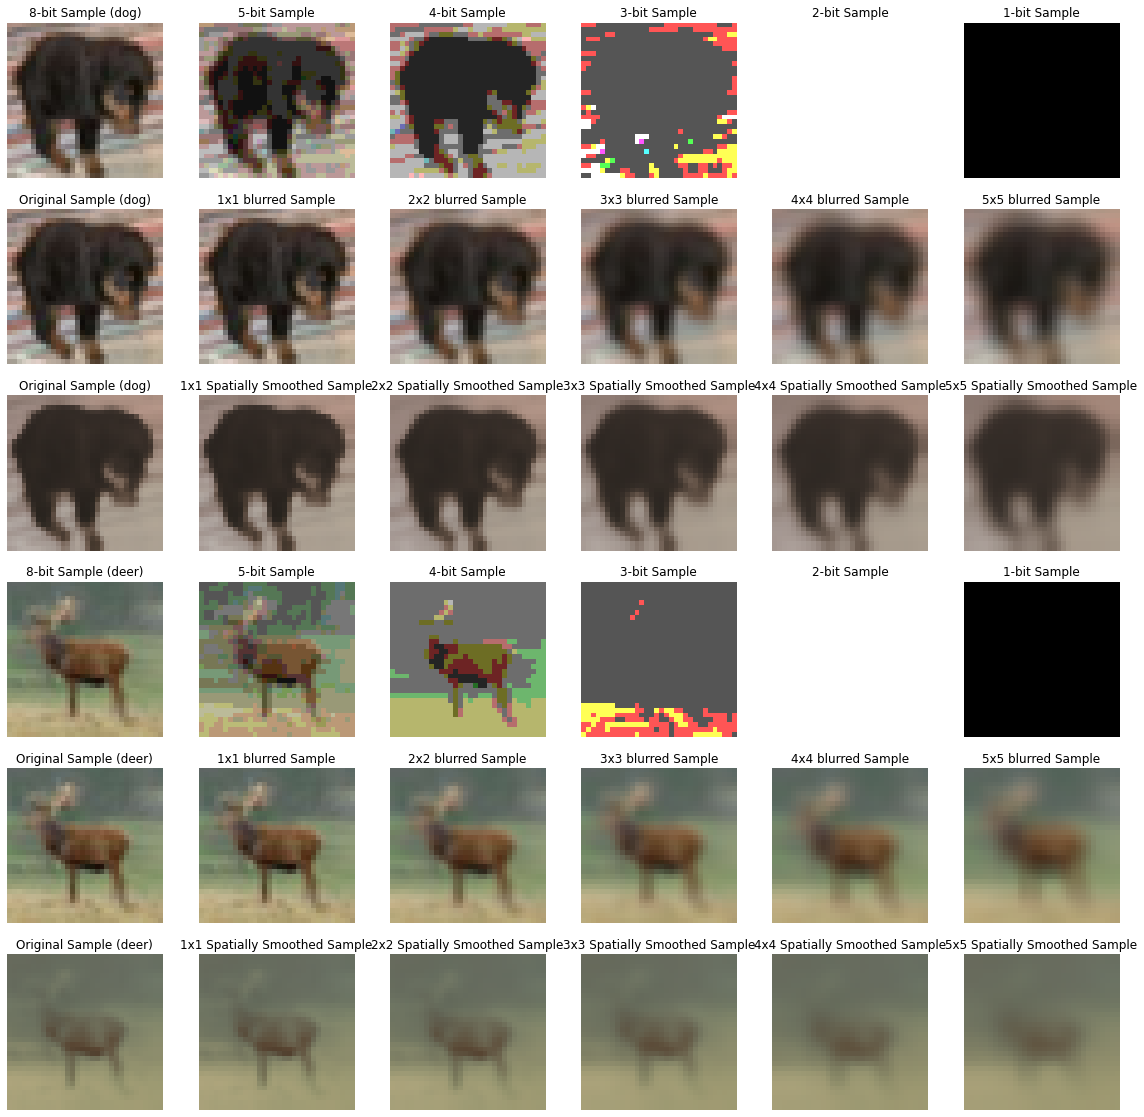

In [ ]:
batch = next(iter(trainloader))
b_x, b_y = batch
num_squeezes = 5
a, b, c = 15, 3, 0.1
results = torch.empty((3*num_squeezes, b_x.shape[0], 3, 32, 32))
for window_size in range(num_squeezes, 0, -1):
    r_x = bitDepthReduction(b_x, num_squeezes - window_size)
    s_x = localSmoothing(b_x, window_size)
    nl_x = nonLocalSmoothing(s_x, a, b, c)
    results[window_size - 1] = r_x
    results[num_squeezes + window_size - 1] = s_x
    results[2*num_squeezes + window_size - 1] = nl_x

fig, ax = plt.subplots(nrows=3*len(b_x), ncols=num_squeezes+1, figsize=(20, 20))

for i in range(0, 3*len(b_x), 3):
    im = b_x[int(i / 2)]
    ax[i, 0].imshow(im.permute((1, 2, 0)).numpy())
    ax[i, 0].set_title('8-bit Sample (' + str(classes[b_y[int(i / 2)]]) + ')')
    ax[i, 0].axis('off')
    ax[i + 1, 0].imshow(im.permute((1, 2, 0)).numpy())
    ax[i + 1, 0].set_title('Original Sample (' + str(classes[b_y[int(i / 2)]]) + ')')
    ax[i + 1, 0].axis('off')
    ax[i + 2, 0].imshow(results[2*num_squeezes][int(i / 3)].permute((1, 2, 0)).numpy())
    ax[i + 2, 0].set_title('Original Sample (' + str(classes[b_y[int(i / 2)]]) + ')')
    ax[i + 2, 0].axis('off')
    for j in range(1, num_squeezes+1):
        plot_triple = (results[j - 1][int(i / 3)], results[j+num_squeezes - 1][int(i / 3)], results[j+2*num_squeezes - 1][int(i / 3)])
        ax[i, j].imshow(plot_triple[0].permute((1, 2, 0)).numpy())
        ax[i, j].set_title(str(num_squeezes - j + 1) + '-bit Sample')
        ax[i, j].axis('off')
        ax[i + 1, j].imshow(plot_triple[1].permute((1, 2, 0)).numpy())
        ax[i + 1, j].set_title(str(j) + 'x' + str(j) + ' blurred Sample')
        ax[i + 1, j].axis('off')
        ax[i + 2, j].imshow(plot_triple[2].permute((1, 2, 0)).numpy())
        ax[i + 2, j].set_title(str(j) + 'x' + str(j) + ' Spatially Smoothed Sample')
        ax[i + 2, j].axis('off')

In [ ]:
# Using the paper and skimage documentation, we settle on these parameters for squeezing.

feature_squeezer_param_dict = {"bit_depth": 5,
                               "local_window": 2, 
                               "nonlocal_params": (15, 3, 0.1)}

# Benchmark adversarial robustness for classification models

In [ ]:
def log_adversarial(wandb_images, wandb_labels, wandb_preds, success=None, wandb_perturbations=None):
    logging_images = []
    if wandb_perturbations is not None:
        logging_perturbations = []
    for i, image in enumerate(wandb_images):
        pred = wandb_preds[i]
        y_pred = torch.argmax(pred, dim=0).item()
        label = wandb_labels[i].item()
        if label == y_pred:
            if success is None:
                grouping = 'Correctly Classified, ' + classes[y_pred]
            else:
                grouping = 'Correctly Classified, ' + classes[y_pred] + ' (Adversarial)'
            caption = 'Pred: ' + classes[y_pred] + ', Confidence: ' + str(nn.functional.softmax(pred, dim=0)[y_pred].item())
        else:
            if success is None:
                grouping = 'Incorrectly Classified, ' + classes[label] 
            else:
                grouping = 'Incorrectly Classified, ' + classes[label] + ' (Adversarial)'
            caption = 'pred: ' + classes[y_pred] + ', Confidence: ' + str(nn.functional.softmax(pred, dim=0)[y_pred].item())
        logging_images.append(wandb.Image(image.detach().cpu().permute(1, 2, 0).numpy(), grouping=grouping, caption=caption))
        if wandb_perturbations is not None:
            logging_perturbations.append(wandb.Image(wandb_perturbations[i].detach().cpu().permute(1, 2, 0).numpy(), grouping=grouping, caption=caption))
    if success is None:
        wandb.log({"Unperturbed Samples": logging_images})
    else:
        wandb.log({"Adversarial Samples": logging_images})
    if wandb_perturbations is not None:
        wandb.log({"Perturbations": logging_perturbations})

In [ ]:
# evaluate ALL-CNN Architecture on adversarial attacks.

# Define classes in the CIFAR dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

model_paths = [root_dir + 'models/BASELINE/final.h5']
model_paths.append(root_dir + 'models/CAW_LR/final.h5')

attack_arr = [("L2 Fast Gradient Attack", "(random_start=False)"),
              ("Linf Fast Gradient Attack", "(random_start=False)"),
              ("Salt And Pepper Noise Attack", "(steps=1000, across_channels=True, channel_axis=-3)"),
              ("L2 DeepFool Attack", "(steps=50, candidates=10, overshoot=0.02, loss='logits')"),
              ("L2 Carlini Wagner Attack", "(binary_search_steps=9, steps=3000, stepsize=0.01, confidence=0, initial_const=0.001, abort_early=True)"),
              ("L2 Projected Gradient Descent Attack", "(rel_stepsize=0.025, abs_stepsize=None, steps=50, random_start=True)")]

for i, (attack_name, func_params) in enumerate(attack_arr):
    for trial in range(1, 6):
        for model_path in model_paths:
            if 'BASELINE' in model_path:
                group = 'Baseline Attack Experiments'
                name = 'Baseline ' + attack_name + ' Experiment ' + str(trial + 1)
            elif 'CAW_LR' in model_path:
                group = 'CAW_LR Attack Experiments'
                name = 'CAW_LR ' + attack_name + ' Experiment ' + str(trial + 1)
            run = wandb.init(project="ese546-finalproj",
                            group=group,
                            name=name,
                            reinit=True)
            with run:
                if 'BASELINE' in model_path or 'CAW_LR' in model_path:
                    model = allcnn_t() # Load saved baseline models
                model.load_state_dict(deepcopy(torch.load(model_path)))
                model = model.to(device)
                model.eval()

                # Use FoolBox to create an easily attackable model
                preprocessing = dict(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], axis=-3)
                # bounds for the image into preprocessing steps (PIL image is [0, 1])
                bounds = (0, 1)
                # Create a foolbox version of our baseline model
                model_fool = PyTorchModel(model, bounds=bounds, device=device, preprocessing=preprocessing)

                # load 16 test images from the FoolBox CIFAR-10 library and for sanity check, test model accuracy on unperturbed inputs.
                images, labels = ep.astensors(*samples(model_fool, dataset='cifar10', batchsize=16))
                clean_acc = accuracy(model_fool, images, labels)

                wandb_images = deepcopy(images).raw
                wandb_labels = deepcopy(labels).raw
                wandb_preds = model_fool(deepcopy(images)).raw
                log_adversarial(wandb_images, wandb_labels, wandb_preds)

                # Initialize an Attack
                attack_name = attack_name.replace(" ", "")
                attack = eval(attack_name+func_params)
                # Define different scales of perturbation
                epsilons = np.linspace(0.0, 1.0, num=26)
                # run Adversarial Attack
                _, advs, success = attack(model_fool, images, labels, epsilons=epsilons)

                # determine the robust accuracy (accuracy against adversarial attack)
                robust_accuracy = 1 - success.float32().mean(axis=-1)

                # log adversarial attacks and robust accuracy 
                for i, (eps, acc) in enumerate(zip(epsilons, robust_accuracy)):
                    wandb_adv_preds = model_fool(deepcopy(advs[i])).raw
                    wandb.log({"Epsilon Magnitude": eps,
                               "Robust Accuracy":   acc.item()})
                    wandb_adv_images = deepcopy(advs[i]).raw
                    wandb_perturbations = wandb_adv_images - wandb_images
                    if i % 4 == 0:
                        log_adversarial(wandb_adv_images, 
                                        wandb_labels, 
                                        wandb_adv_preds, 
                                        deepcopy(success[i]).raw, 
                                        deepcopy(wandb_perturbations))

# Create Adversarial Detection Dataset

In [ ]:
# Define classes in the CIFAR dataset

# Load saved baseline model
baseline_path = root_dir + 'models/BASELINE/final.h5'
baseline_model = allcnn_t()
baseline_model.load_state_dict(deepcopy(torch.load(baseline_path)))
baseline_model = baseline_model.to(device)
baseline_model.eval()

# Use FoolBox to create an easily attackable model
preprocessing = dict(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], axis=-3)
# bounds for the image into preprocessing steps (PIL image is [0, 1])
bounds = (0, 1)
# Create a foolbox version of our baseline model
baseline_fool = PyTorchModel(baseline_model, bounds=bounds, device=device, preprocessing=preprocessing)

# Use the test dataset to generate adversarial samples for training our detector later on
transform_test = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=20,
                                         shuffle=False, pin_memory=True)

epsilons = np.linspace(0.0, 0.5, num=5)
labels = torch.empty((10000, ), device=device)
data_attack = fb.attacks.DatasetAttack(distance=fb.distances.LpDistance(2))
for i, batch in enumerate(testloader):
    x, y = batch
    x, y = x.to(device), y.to(device)
    data_attack.feed(baseline_fool, x)
    data_attack.process_raw()
    labels[20*i:20*i+20] = y
X_data = data_attack.inputs
y_preds = data_attack.outputs
legitimate_trainset = TensorDataset(deepcopy(X_data).raw, deepcopy(labels))
torch.save(deepcopy(X_data).raw, '/content/drive/MyDrive/ESE546_Final_Project/data/AdversarialDetectionTrainingData-Legitimate.pt')
torch.save(deepcopy(labels), '/content/drive/MyDrive/ESE546_Final_Project/data/AdversarialDetectionTrainingLabels-Legitimate.pt')

Num parameters:  1667166
Files already downloaded and verified


In [ ]:
# Create Adversarial Samples for Training

for i in range(0, 10000, 20):
    _, advs, success = data_attack(baseline_fool, X_data[i:i+20], labels[i:i+20], epsilons=epsilons)
    adv_tensor = torch.empty((len(advs), advs[0].shape[0], 3, 32, 32))
    adv_labels = torch.empty((len(advs), advs[0].shape[0], 2))
    for j, sample in enumerate(advs):
        adv_tensor[j] = sample.raw
        adv_labels[j] = torch.vstack((labels[i:i+20], torch.ones((20, ), device=device))).T
    if i == 0:
        X_data_adversarial = adv_tensor
        labels_adversarial = adv_labels
    elif adv_tensor.shape[1] == X_data_adversarial.shape[1]:
        X_data_adversarial = torch.vstack((X_data_adversarial, adv_tensor))
        labels_adversarial = torch.vstack((labels_adversarial, adv_labels))

adversarial_trainset = TensorDataset(deepcopy(X_data_adversarial), deepcopy(labels_adversarial))
torch.save(deepcopy(X_data_adversarial), '/content/drive/MyDrive/ESE546_Final_Project/data/AdversarialDetectionTrainingData-Adversarial.pt')
torch.save(deepcopy(labels_adversarial), '/content/drive/MyDrive/ESE546_Final_Project/data/AdversarialDetectionTrainingLabels-Adversarial.pt')

In [ ]:
# Create a Dataset with mixed adversarial samples and legitimate samples (evenly distributed)
X_train_detection = torch.empty((2000, 3, 32, 32))
y_train_detection = torch.empty((2000, 2))
adversarial_inds = torch.randperm(2500)[:50]
counter = 0
for el in adversarial_inds:
    x, y = adversarial_trainset[el]
    for i in range(len(x)):
        X_train_detection[counter+i] = x[i]
        y_train_detection[counter+i] = y[i]
    counter += len(x)

legitimate_inds = torch.randperm(10000)[:1000]
for el in legitimate_inds:
    x, y = legitimate_trainset[el]
    X_train_detection[counter] = x
    y_train_detection[counter] = torch.tensor([y, 0.])
    counter += 1
detectionset = TensorDataset(X_train_detection, y_train_detection)

#Feature Squeezing Network

In [ ]:
# WandB – Initialize a new run
wandb.init(project="ese546-finalproj",
           group="Feature Squeezing Threshold Finding",
           name="Bit-Depth Reduction Experiment 3")
wandb.watch_called = False # Re-run the model without restarting the runtime, unnecessary after our next release

# WandB – Config is a variable that holds and saves hyperparameters and inputs
config = wandb.config                               # Initialize config
config.batch_size = 1                               # input batch size for training
#config.test_batch_size = int(256 / 2.5)            # input batch size for testing
#config.epochs = 35                                 # number of epochs to train
#config.lr = 0.1                                    # learning rate
#config.momentum = 0.9                              # SGD momentum
#config.weight_decay = 1e-3                         # Weight decay
#config.nesterov = True                             # Nesterov momentum
#config.seed = 42                                   # random seed (default: 42)
#config.lr_steps = [int(0.4*config.epochs), int(0.8*config.epochs)]

wandb: Currently logged in as: geande (use `wandb login --relogin` to force relogin)


In [ ]:
class FeatureSqueezingNetwork(nn.Module):
    def __init__(self, squeeze_params=None, model_name='BASELINE', device=device):
        super().__init__()
        if squeeze_params is None:
            self.squeeze_params = {'bitreduce': 5, 
                                    'localsmooth': 2,
                                    'nonlocalsmooth': (15, 3, 0.1)}
        else:
            self.squeeze_params = squeeze_params
        self.squeeze_dim = len(self.squeeze_params)
        self.model_path = root_dir + 'models/' + model_name + '/'
        self.device = device
        ckpts = list(os.listdir(self.model_path))
        if len(ckpts) == 0:
            return 'Error, no such file';
        elif 'final.h5' not in ckpts:
            return 'Error, no such file';
        else:
            if model_name == 'BASELINE' or model_name == 'CAW_LR':
                self.model = allcnn_t()
                self.model.load_state_dict(deepcopy(torch.load(self.model_path + 'final.h5')))
                self.model = self.model.to(self.device)
            #### Add functionality for MobileNet

        if 'bitreduce' in self.squeeze_params.keys():
            if model_name == 'BASELINE' or model_name == 'CAW_LR':
                self.squeezer = allcnn_t()
                self.squeezer.load_state_dict(deepcopy(torch.load(self.model_path + 'final.h5')))
                self.squeezer = self.squeezer.to(self.device)
            #### Add functionality for MobileNet
        if 'localsmooth' in self.squeeze_params.keys():
            if model_name == 'BASELINE' or model_name == 'CAW_LR':
                self.squasher = allcnn_t()
                self.squasher.load_state_dict(deepcopy(torch.load(self.model_path + 'final.h5')))
                self.squasher = self.squasher.to(self.device)
            #### Add functionality for MobileNet
        if 'nonlocalsmooth' in self.squeeze_params.keys():
            if model_name == 'BASELINE' or model_name == 'CAW_LR':
                self.squisher = allcnn_t()
                self.squisher.load_state_dict(deepcopy(torch.load(self.model_path + 'final.h5')))
                self.squisher = self.squisher.to(self.device)
            #### Add functionality for MobileNet
        return;

    def forward(self, x):
        preds = self.model(deepcopy(x))
        preds_dict = {'preds': preds}

        if 'bitreduce' in self.squeeze_params.keys():
            d_x = bitDepthReduction(deepcopy(x), self.squeeze_params['bitreduce'])
            squeeze_preds = self.squeezer(d_x)
            preds_dict['squeezed'] = squeeze_preds
            
        if 'localsmooth' in self.squeeze_params.keys():
            s_x = localSmoothing(deepcopy(x), self.squeeze_params['localsmooth'])
            squash_preds = self.squasher(s_x)
            preds_dict['squashed'] = squash_preds

        if 'nonlocalsmooth' in self.squeeze_params.keys():
            a, b, c = self.squeeze_params['nonlocalsmooth']
            q_x = nonLocalSmoothing(deepcopy(x), a, b, c)
            squaish_preds = self.squisher(q_x)
            preds_dict['squished'] = squash_preds
        return preds_dict;

In [ ]:
def collect_stats(threshold, TP, TN, FN, FP):
    # Compute Accuracy of Detection
    accuracy = (TP + TN) / (TP + TN + FN + FP)
    # Compute Precision of Detection
    precision = TP / (TP + FP)
    # Compute Recall of Detection
    recall = TP / (TP + FN)
    # Compute F1 Score of Detection
    f1score = 2 * (precision * recall) / (precision + recall)
    wandb.log({"L1 Detection Threshold": threshold,
               "Detection Accuracy": accuracy,
               "Detection Precision": precision, 
               "Detection Recall": recall, 
               "Detection F1 Score": f1score})
    return;

def L1Histograms(squeeze_adv_arr, squeeze_legit_arr, 
                 squash_adv_arr=None, squash_legit_arr=None, 
                 squish_adv_arr=None, squish_legit_arr=None):
    if squash_adv_arr is None or len(squash_adv_arr) == 0:
        wandb.log({
                    "Squeezer L1 Histogram (Adversaries)": wandb.Histogram(squeeze_adv_arr),
                    "Squeezer L1 Histogram (Legitimate)": wandb.Histogram(squeeze_legit_arr)
        })
    else:
        wandb.log({
                    "Squeezer L1 Histogram (Adversaries)": wandb.Histogram(squeeze_adv_arr),
                    "Squeezer L1 Histogram (Legitimate)": wandb.Histogram(squeeze_legit_arr),
                    "Squasher L1 Histogram (Adversaries)": wandb.Histogram(squash_adv_arr),
                    "Squasher L1 Histogram (Legitimate)": wandb.Histogram(squash_legit_arr)
        })
    return;

In [ ]:
adv_label_dict = {'0': 'Legitimate',
                  '1': 'Adversarial'}

# Create a trainloader of shuffled Adversarial and Legitimate Samples
detectionloader = torch.utils.data.DataLoader(detectionset, batch_size=1,
                                                shuffle=True, pin_memory=True)

squeeze_params = {'bitreduce': 5}
                  # 'localsmooth': 2}
# Define model, starting with just bit depth reduction
fsn = FeatureSqueezingNetwork(squeeze_params=squeeze_params)
fsn = fsn.to(device)
fsn.eval()

# Threshold Finding
thresholds = torch.arange(0., 1, 0.01)

for threshold in thresholds:
    TP = 0 # True Detections of Adversarial samples
    TN = 0 # True Detections of Legitimate samples
    FN = 0 # No Detection of Adversarial samples
    FP = 0 # Bad Detection (gt: Legitimate, pred: Adversarial)
    l1_diff_squeeze_adv_arr = []
    l1_diff_squeeze_legit_arr = []
    l1_diff_squash_adv_arr = []
    l1_diff_squash_legit_arr = []
    l1_diff_squish_adv_arr = []
    l1_diff_squish_legit_arr = []

    for i, batch in enumerate(detectionloader):
        x, y = batch
        x, y = x.to(device), y.squeeze(0).to(device)
        preds = fsn(x)
        adverse = False
        if 'squeezed' in preds.keys():
            #class_preds = (torch.argmax(preds['preds']).item(), torch.argmax(preds['squeezed']).item())
            l1_diff_squeeze = torch.sum(torch.abs(preds['preds'] - preds['squeezed']), dim=1).item()
            if l1_diff_squeeze > threshold.item():
                l1_diff_squeeze_adv_arr.append(l1_diff_squeeze)
                adverse = True;
            else:
                l1_diff_squeeze_legit_arr.append(l1_diff_squeeze)
        
        if 'squashed' in preds.keys():
            #class_preds = (torch.argmax(preds['preds']).item(), torch.argmax(preds['squeezed']).item(), torch.argmax(preds['squashed']).item())
            l1_diff_squash = torch.sum(torch.abs(preds['preds'] - preds['squashed']), dim=1).item()
            if l1_diff_squash > threshold.item():
                l1_diff_squash_adv_arr.append(l1_diff_squash)
                adverse = True
            else:
                l1_diff_squash_legit_arr.append(l1_diff_squash)
        
        if 'squished' in preds.keys():
            #class_preds = (torch.argmax(preds['preds']).item(), torch.argmax(preds['squeezed']).item(), torch.argmax(preds['squashed']).item())
            l1_diff_squish = torch.sum(torch.abs(preds['preds'] - preds['squished']), dim=1).item()
            if l1_diff_squish > threshold.item():
                l1_diff_squish_adv_arr.append(l1_diff_squish)
                adverse = True
            else:
                l1_diff_squish_legit_arr.append(l1_diff_squish)

        if adverse == y[1].item() and adverse == True:
            TP += 1
        elif adverse == y[1].item() and adverse == False:
            TN += 1
        elif adverse != y[1].item() and adverse == True:
            FP += 1
        elif adverse != y[1].item() and adverse == False:
            FN += 1
        # print('Sample is predicted to be: ', adv_label_dict[str(int(adverse))])
        # print('Class Prediction: ', classes[int(class_preds[0])])
        # if 'squeezed' in preds.keys():
        #     print('Squeezed Class Prediction: ', classes[int(class_preds[1])])
        # if 'squashed' in preds.keys():
        #     print('Squeezed Class Prediction: ', classes[int(class_preds[1])])
        # print()
    collect_stats(threshold, TP, TN, FN, FP)
    #L1Histograms(l1_diff_squeeze_adv_arr, l1_diff_squeeze_legit_arr, l1_diff_squash_adv_arr, l1_diff_squash_legit_arr)

Num parameters:  1667166
Num parameters:  1667166


#Training the Feature Squeezing Network

In [ ]:
def my_loss_fcn(preds, targets):
    '''
        inputs:
            ouputs - dict of tensors of batchwise outputs from fsn model class predictions
            targets - tensor of labels (class label, adversarial label)
        outputs:
            loss - dict of class and adversarial losses, may or may not use both, 
    '''
    adverse = {}
    class_preds = {}
    class_preds['preds'] = torch.argmax(preds['preds'])#.item()
    if 'squeezed' in preds.keys():
        class_preds['squeezed'] = torch.argmax(preds['squeezed'])#.item())
        l1_diff_squeeze = torch.sum(torch.abs(preds['preds'] - preds['squeezed']), dim=1)#.item()
        threshold_arr = threshold.item()*torch.ones_like(l1_diff_squeeze)
        adverse['squeezed'] = l1_diff_squeeze > threshold_arr
        
    if 'squashed' in preds.keys():
        class_preds['squashed'] = torch.argmax(preds['squashed'])#.item())
        l1_diff_squash = torch.sum(torch.abs(preds['preds'] - preds['squashed']), dim=1)#.item()
        threshold_arr = threshold.item()*torch.ones_like(l1_diff_squeeze)
        adverse['squashed'] = l1_diff_squeeze > threshold_arr
    
    if 'squished' in preds.keys():
        class_preds['squished'] = torch.argmax(preds['squashed'])#.item())
        l1_diff_squish = torch.sum(torch.abs(preds['preds'] - preds['squished']), dim=1)#.item()
        threshold_arr = threshold.item()*torch.ones_like(l1_diff_squeeze)
        adverse['squished'] = l1_diff_squeeze > threshold_arr
    loss = {}
    for i, (net_name, class_pred) in enumerate(class_preds.items()):
        if i == 0:
            loss['adversarial']

In [ ]:
# Lets just choose a threshold to start with
theshold = 0.6

In [ ]:
# validation inner loop
def validate(model, test_loader):
    val_correct = 0
    epoch_val_loss = 0
    val_total = 0
    for i, (images, labels) in enumerate(test_loader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        _, predicted = torch.max(outputs.data, 1)
        val_correct += (predicted == labels).sum().item()
        epoch_val_loss += loss.item()
        val_total += labels.size(0)

    epoch_val_error = 1.0 - (val_correct / val_total)
    epoch_val_loss = epoch_val_loss / val_total
    return epoch_val_error, epoch_val_loss

# The training loop
def train(net, optimizer, scheduler, criterion, train_loader, test_loader, epochs):
    model = net.to(device)
    total_step = len(train_loader)
    overall_step = 0
    for epoch in range(epochs):
        correct = 0
        epoch_loss = 0
        total = 0
        model.train()
        for i, (images, labels) in enumerate(train_loader):
            if scheduler is None:
                # Update LR according to Cosine Annealing Warmup (discussed further down)
                next_lr = lr_scheduler_impl(epoch, i)
                for g in optimizer.param_groups:
                    g['lr'] = next_lr
            else:
                next_lr = scheduler.get_last_lr()[0]
            # Move tensors to configured device
            images = images.to(device)
            labels = labels.to(device)
            # Forward Pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            # Compute loss and error
            _, predicted = torch.max(outputs.data, 1)
            iter_correct = (predicted == labels).sum().item()
            correct += iter_correct
            epoch_loss += loss.item()
            total += labels.size(0)
            # Log per weight Update
            wandb.log({"Iteration Training Loss": loss.item(),
                       "Iteration Training Error": 1.0 - (iter_correct / labels.size(0)),
                       "Iteration LR": next_lr,
                       "Iteration": epoch*total_step + i})
            # Backpropogation and SGD
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (i+1) % config.batch_size == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, epochs, i+1, total_step, loss.item()))
        # log training metrics
        epoch_error = 1.0 - (correct / total)
        epoch_loss = epoch_loss / total
        wandb.log({"Epoch Training Loss": epoch_loss,
                   "Epoch Training Error": epoch_error,
                   "Epoch LR": next_lr,
                   "Epoch": epoch,
                   "Iteration": (epoch + 1)*total_step})

        ################ Validation ################
        model.eval()
        with torch.no_grad():
            epoch_val_error, epoch_val_loss = validate(model, test_loader)
        if scheduler is not None:
            scheduler.step()
        # log validation metrics
        wandb.log({"Validation Loss": epoch_val_loss,
                   "Validation Error": epoch_val_error,
                   "Epoch": epoch,
                   "Iteration": (epoch + 1)*total_step})
        print('Error of the network on the test images: {} %'.format(100 * epoch_val_error))

        if (epoch+1) % 5 == 0 and epoch+1 != epochs:
            if epoch+1 < 10:
                model_name = "epoch0" + str(epoch+1) + ".h5"
            else:
                model_name = "epoch" + str(epoch+1) + ".h5"
            if scheduler is None:
                save_name = root_dir + "models/CAW_LR/" + model_name
            else:
                save_name = root_dir + "models/BASELINE/" + model_name
            torch.save(model.state_dict(), save_name)